## Import Packages

In [1]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [0]:
# Install packages that aren't available by default in google colab
!pip install -q pydicom

In [3]:
# IMPORT PACKAGES
import warnings; warnings.filterwarnings('ignore')
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging; logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import os, zipfile, random, csv
import seaborn as sns
import pydicom as dcm
from glob import glob
import cv2

%matplotlib inline

# SET VARIABLES
PATH = '/content/drive/My Drive/Pneumonia_Detection/'; os.chdir(PATH)
DATA_DIR = os.path.join(PATH + 'data/')
TRAIN_IMAGES = os.path.join(DATA_DIR + 'stage_2_train_images/')
TEST_IMAGES = os.path.join(DATA_DIR + 'stage_2_test_images/')
OUTPUT_DIR = os.path.join(PATH + 'output/')
MODEL_WEIGHTS = os.path.join(PATH + 'model_weights/')
if not os.path.exists(MODEL_WEIGHTS): os.makedirs(MODEL_WEIGHTS)

# CUSTOM MODULE
from module.densenet121 import *

# SET RANDOM SEED
random_state = 2020
np.random.seed(random_state)

# USE GPU FOR MODEL TRAINING
import tensorflow as tf
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# tf.config.set_soft_device_placement(True)
# tf.debugging.set_log_device_placement(True)
# list_gpu = tf.config.experimental.list_physical_devices(device_type='GPU')
# for gpu in list_gpu: tf.config.experimental.set_memory_growth(gpu, True)
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


Using TensorFlow backend.


## Read Data & Prep for Model
* Read a pickle file that was saved as part of [EDA & Data Prep](https://nbviewer.jupyter.org/github/sharmapratik88/Capstone_Pneumonia_Detection/blob/master/Pneumonia_Detection_EDA_%26_Data_Prep.ipynb)

In [4]:
# Read `train_class_features.pkl` file, saved as EDA & Data Prep Module
train_class = pd.read_pickle(OUTPUT_DIR + 'train_class_features.pkl')
display(train_class.shape, train_class.head())

(30227, 12)

,patientId,x,y,width,height,Target,number_of_boxes,class,path,PatientSex,PatientAge,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,data/stage_2_train_images/0004cfab-14fd-4e49-8...,F,51.0,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,data/stage_2_train_images/00313ee0-9eaa-42f4-b...,F,48.0,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,data/stage_2_train_images/00322d4d-1c29-4943-a...,M,19.0,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,Normal,data/stage_2_train_images/003d8fa0-6bf1-40ed-b...,M,28.0,PA
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,Lung Opacity,data/stage_2_train_images/00436515-870c-4b36-a...,F,32.0,AP


In [5]:
# A dataframe with paths, classes and targets
print('Prepare a dataframe with paths, classes and targets'); print('--'*40)
path_class_target = train_class[['path', 'class', 'Target']].copy(deep = True)
path_class_target.drop_duplicates(inplace = True)
display(path_class_target.shape, path_class_target.nunique())
print('Distribution of target and classes')
display(path_class_target['Target'].value_counts(), path_class_target['class'].value_counts())

Prepare a dataframe with paths, classes and targets
--------------------------------------------------------------------------------


(26684, 3)

path      26684
class         3
Target        2
dtype: int64

Distribution of target and classes


0    20672
1     6012
Name: Target, dtype: int64

No Lung Opacity / Not Normal    11821
Normal                           8851
Lung Opacity                     6012
Name: class, dtype: int64

In [6]:
# Split the data in train, valid and test sets
print('Split the data in train, valid and test sets'); print('--'*40)
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(path_class_target['path'],
                                                    path_class_target['class'],
                                                    test_size = 0.2, 
                                                    random_state = random_state, 
                                                    shuffle = True,
                                                    stratify = path_class_target['class'])

X_train, X_valid, y_train, y_valid = train_test_split(X_train, 
                                                      y_train, 
                                                      test_size = 0.3, 
                                                      random_state = random_state, 
                                                      shuffle = True,
                                                      stratify = y_train)

X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

Split the data in train, valid and test sets
--------------------------------------------------------------------------------


((14942,), (6405,), (5337,), (14942,), (6405,), (5337,))

In [7]:
print('Training, Validation and Test set is ~equally distributed on classes'); print('--'*40)
print('Distribution of class in the training set:'); display(pd.Series(y_train).value_counts(normalize = True).round(2))
print('\nDistribution of class in the validation set:'); display(pd.Series(y_valid).value_counts(normalize = True).round(2))
print('\nDistribution of class in the test set:'); display(pd.Series(y_test).value_counts(normalize = True).round(2))

Training, Validation and Test set is ~equally distributed on classes
--------------------------------------------------------------------------------
Distribution of class in the training set:


No Lung Opacity / Not Normal    0.44
Normal                          0.33
Lung Opacity                    0.23
Name: class, dtype: float64


Distribution of class in the validation set:


No Lung Opacity / Not Normal    0.44
Normal                          0.33
Lung Opacity                    0.23
Name: class, dtype: float64


Distribution of class in the test set:


No Lung Opacity / Not Normal    0.44
Normal                          0.33
Lung Opacity                    0.23
Name: class, dtype: float64

In [8]:
print('Create Training, Validation and Test Dataframe with Path and Target'); print('--'*40)

df_train = (path_class_target.merge(pd.Series(X_train), 
                                    on = 'path', 
                                    how = 'right')
          .drop('class', axis = 1))

df_valid = (path_class_target.merge(pd.Series(X_valid), 
                                    on = 'path', 
                                    how = 'right')
          .drop('class', axis = 1))

df_test = (path_class_target.merge(pd.Series(X_test), 
                                    on = 'path', 
                                    how = 'right')
          .drop('class', axis = 1))

print('Shape of the dataframes:\nTRAIN:{}\nVALID:{}\nTEST:{}'.format(df_train.shape, df_valid.shape, df_test.shape))

Create Training, Validation and Test Dataframe with Path and Target
--------------------------------------------------------------------------------
Shape of the dataframes:
TRAIN:(14942, 2)
VALID:(6405, 2)
TEST:(5337, 2)


In [9]:
print('Save the train, valid and test dataframes for future use');print('--'*40)
df_train.to_pickle(OUTPUT_DIR + 'train_data.pkl')
df_valid.to_pickle(OUTPUT_DIR + 'valid_data.pkl')
df_test.to_pickle(OUTPUT_DIR + 'test_data.pkl')

Save the train, valid and test dataframes for future use
--------------------------------------------------------------------------------


## Model - DenseNet121

In [0]:
# Model Parameters
BATCH_SIZE = 64
IMAGE_SIZE = 128

In [11]:
print('Create a base `DenseNet121` model'); print('--'*40)
base_model = DenseNet121(weights ='imagenet', include_top = False, 
                        input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation = 'relu')(x)

predictions = Dense(1, activation = 'sigmoid')(x)
model = Model(inputs = base_model.input, outputs = predictions)

Create a base `DenseNet121` model
--------------------------------------------------------------------------------


In [12]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [0]:
# Learning Rate Scheduler
lrscheduler = LearningRateScheduler(lrate_epoch)
# lrscheduler = LearningRateScheduler(cosine_annealing)

# Adam optimizer
opt = Adam(lr = 0.001)

# Select adam optimizer, loss = binary cross entropy, metrics = accuracy
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Create a model checkpoint
cp = ModelCheckpoint(filepath = MODEL_WEIGHTS + 'best_densenet.h5', verbose = 1, save_best_only = True)
# es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 2)

# csv logger
csv_logger = CSVLogger(MODEL_WEIGHTS + 'logs.csv', append = True)

# callbacks
callbacks = [cp, csv_logger, lrscheduler]

In [14]:
print('Lets fit the model.....')
print('Best accuracy achieved:\nTrain: 86.19%, Val: 85.61%')
print('Best loss achieved:\nTrain: 0.3202, Val: 0.3169'); print('--'*40)
# model.fit_generator(generator = train_generator(df_train, IMAGE_SIZE, BATCH_SIZE),
#                     steps_per_epoch = (len(df_train) // BATCH_SIZE) + 1,
#                     epochs = 20,
#                     verbose = 1,
#                     callbacks = callbacks,
#                     validation_data = valid_generator(df_valid, IMAGE_SIZE, BATCH_SIZE),
#                     validation_steps = (len(df_valid) // BATCH_SIZE) + 1,
#                     use_multiprocessing = True,
#                     workers = 4)

Lets fit the model.....
Best accuracy achieved:
Train: 86.19%, Val: 85.61%
Best loss achieved:
Train: 0.3202, Val: 0.3169
--------------------------------------------------------------------------------


In [0]:
# print('Save the final weights'); print('--'*40)
# model.save(MODEL_WEIGHTS + 'best_densenet_final.h5')

In [16]:
print('Reloading model weights and lets evaluate on validation set'); print('--'*40)
model.load_weights(MODEL_WEIGHTS + 'best_densenet.h5')

Reloading model weights and lets evaluate on validation set
--------------------------------------------------------------------------------


In [17]:
print('Evaluate the model on validation data'); print('--'*40)
score = model.evaluate_generator(generator = valid_generator(df_valid, IMAGE_SIZE, BATCH_SIZE), 
                                 steps = (len(df_valid) // BATCH_SIZE) + 1, pickle_safe = False)
print(score)

Evaluate the model on validation data
--------------------------------------------------------------------------------
[0.807843029499054, 0.8032786846160889]


In [18]:
print('Predict on the validation data'); print('--'*40)
pred_generator = pred_generator(df_valid, IMAGE_SIZE, BATCH_SIZE)
valid_pred = model.predict_generator(generator = pred_generator, 
                                     steps = (len(df_valid) // BATCH_SIZE) + 1)

Predict on the validation data
--------------------------------------------------------------------------------


In [19]:
print('Predict on the Test data'); print('--'*40)
from module.densenet121 import test_pred_generator
test_pred_generator = test_pred_generator(df_test, IMAGE_SIZE, BATCH_SIZE)
test_pred = model.predict_generator(generator = test_pred_generator, 
                                 steps = (len(df_test) // BATCH_SIZE) + 1)

Predict on the Test data
--------------------------------------------------------------------------------


Train/Validation Accuracy/Loss Comparison
--------------------------------------------------------------------------------


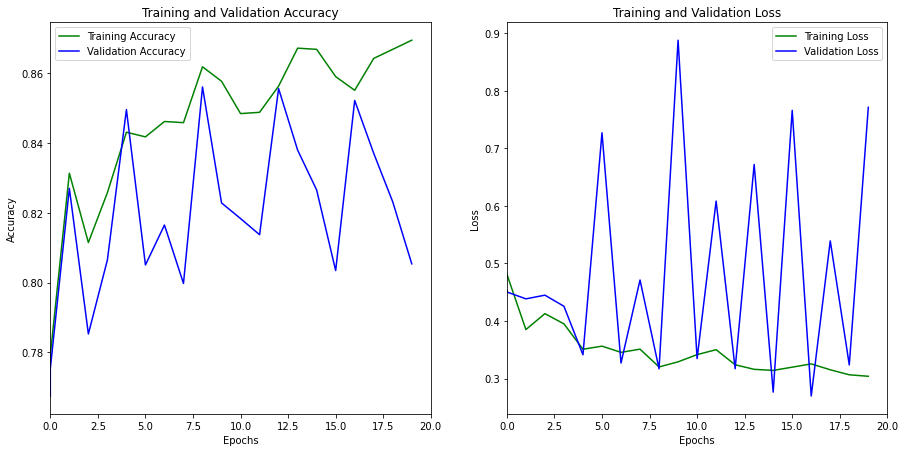

In [20]:
print('Train/Validation Accuracy/Loss Comparison'); print('--'*40)
logs = pd.read_csv(MODEL_WEIGHTS + 'logs.csv')
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7.2))

ax1.plot(logs['epoch'], logs['accuracy'], 'g', label = 'Training Accuracy')
ax1.plot(logs['epoch'], logs['val_accuracy'], 'b', label = 'Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_xlim(0, 20)
ax1.legend()

ax2.plot(logs['epoch'], logs['loss'], 'g', label = 'Training Loss')
ax2.plot(logs['epoch'], logs['val_loss'], 'b', label = 'Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_xlim(0, 20)
ax2.legend()

plt.show()

### MODEL TUNING TO FOLLOW NEXT